# Aula 4 - ETL - Load

**Objetivos:**

- Aplicar Técnicas de Redução de Dimensão
  - Como constatado no [notebook da aula 2 e 3](./etl_aulas_2_e_3.ipynb), há um desbalanceamento entre as raças dos motoristas - quase 3 vezes mais motoristas brancos. 
  - Aplicar técnicas de undersampling - `easy ensemble`  
  - Analisar novamente utilizando `mutual information` se o atributo mais determinante de ser preso mudou.
- Aplicar Técnicas de Amostragem
    - Aplicar PCA: 
      - Treinar Árvore de Decisão e medir a acurácia 
      - Aplicar o PCA - 
      - Treinar Árvore de Decisão e medir a acurácia 
      - A acurácia mudou?


## Carregando Dataset

In [316]:
import pandas as pd
import numpy as np

pd.plotting.register_matplotlib_converters()
import matplotlib.pyplot as plt

%matplotlib inline
import seaborn as sns

In [317]:
csv_path = "../data/police.csv"
df = pd.read_csv(csv_path)
df.fillna("NA")
df.head()

,stop_date,stop_time,county_name,driver_gender,driver_age_raw,driver_age,driver_race,violation_raw,violation,search_conducted,search_type,stop_outcome,is_arrested,stop_duration,drugs_related_stop
0,2005-01-02,01:55,NaN,M,1985.0,20.0,White,Speeding,Speeding,False,NaN,Citation,False,0-15 Min,False
1,2005-01-18,08:15,NaN,M,1965.0,40.0,White,Speeding,Speeding,False,NaN,Citation,False,0-15 Min,False
2,2005-01-23,23:15,NaN,M,1972.0,33.0,White,Speeding,Speeding,False,NaN,Citation,False,0-15 Min,False
3,2005-02-20,17:15,NaN,M,1986.0,19.0,White,Call for Service,Other,False,NaN,Arrest Driver,True,16-30 Min,False
4,2005-03-14,10:00,NaN,F,1984.0,21.0,White,Speeding,Speeding,False,NaN,Citation,False,0-15 Min,False


In [318]:
from etl.main import PoliceDatasetEtl


police_dataset_etl = PoliceDatasetEtl(df)
featured_df = police_dataset_etl.clean_transform()

In [319]:
display(featured_df.head())
display(print("Baseline features:"))
display(police_dataset_etl.baseline_features)

,stop_date,stop_time,county_name,driver_gender,driver_age_raw,driver_age,driver_race,violation_raw,violation,search_conducted,...,stop_duration,drugs_related_stop,stop_outcome_level,violation_level,proportional_stop_outcome,stop_time_discrete,is_black_or_hispanic,stop_time_discrete_bins,driver_age_bins,counter
0,2005-01-02,01:55,NaN,M,1985.0,20.0,White,Speeding,Speeding,False,...,0-15 Min,False,3,5,0.6,155,False,dawn,jovem,1
1,2005-01-18,08:15,NaN,M,1965.0,40.0,White,Speeding,Speeding,False,...,0-15 Min,False,3,5,0.6,815,False,morning,adulto,1
2,2005-01-23,23:15,NaN,M,1972.0,33.0,White,Speeding,Speeding,False,...,0-15 Min,False,3,5,0.6,2315,False,night,adulto,1
3,2005-02-20,17:15,NaN,M,1986.0,19.0,White,Call for Service,Other,False,...,16-30 Min,False,5,1,5.0,1715,False,evening,jovem,1
4,2005-03-14,10:00,NaN,F,1984.0,21.0,White,Speeding,Speeding,False,...,0-15 Min,False,3,5,0.6,1000,False,morning,jovem,1


Baseline features:


None

['is_arrested',
 'driver_race',
 'driver_gender',
 'stop_outcome_level',
 'violation_level',
 'search_conducted',
 'search_type',
 'drugs_related_stop',
 'stop_time_discrete_bins',
 'driver_age_bins']

## Utilizando Mutual Information no Raw Dataset

In [320]:
from sklearn.feature_selection import mutual_info_regression

class CalculateMI:
    """
    Calculate the mutual information between each feature and the target
    """
    def __init__(self,
        df: pd.DataFrame,
        target: str,
        baseline_features: list,
        categorical_features: list,
    ):
        self._df = df
        self._target = target
        self._baseline_features = baseline_features
        self._categorical_features = categorical_features 
        
    def calculate_mi_scores(self) -> pd.Series:
        """
        Calculate the mutual information between each feature and the target
        """
        X, y = self._get_x_y()
        X, discrete_features = self._factorize(X)
        
        mi_scores = mutual_info_regression(
            X,
            y,
            discrete_features=discrete_features,
        )
        mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
        mi_scores = mi_scores.sort_values(ascending=False)
        return mi_scores
    
    def _get_x_y(self) -> tuple:
        """
        Returns X and y to calculate MI
        """
        X = self._df.copy()
        y = X.pop(self._target)
        X = X[self._baseline_features]
        return X, y
    
    def _factorize(self, X: pd.DataFrame) -> tuple:
        """
        Factorize categorical features and return X and discrete_features
        """
        for col in X.select_dtypes("object"):
            X[col], _ = X[col].factorize()
            
        for col in self._categorical_features:
            X[col], _ = X[col].factorize()
            

        
        discrete_features = X.dtypes == int
        return X, discrete_features
    


In [321]:
X = featured_df.copy()
X.pop("stop_outcome_level")

mi_baseline_f = police_dataset_etl.baseline_features

for attribute_to_remove in ["stop_outcome_level", "is_arrested", "driver_gender"]:
    mi_baseline_f.remove(attribute_to_remove)

mi_categorical_f = ["stop_time_discrete_bins", "driver_age_bins"]

raw_calculate_mi = CalculateMI(
    df=X,
    target="is_arrested",
    baseline_features=mi_baseline_f,
    categorical_features=mi_categorical_f,
)

mi_scores = raw_calculate_mi.calculate_mi_scores()

In [322]:
## Defining Plot Function
def plot_mi_scores(scores, title = "RAW - Mutual Information Scores"):
    plt.figure(dpi=100, figsize=(8, 2))
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title(title)

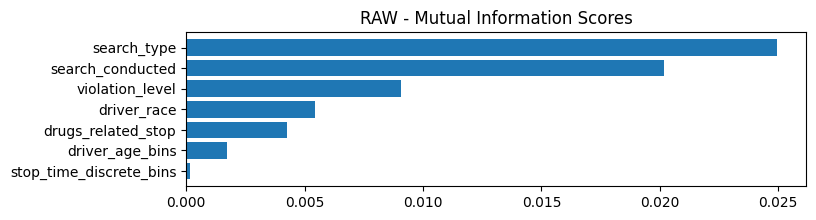

In [323]:
plot_mi_scores(mi_scores)

## Aplicando Easy Ensemble no Dataset

- Após a aplicação do `easy ensemble`, o atributo mais determinante de ser preso mudou?
  - Resposta: SIM, o atributo de raça passou a ser mais determinante que o gênero

In [324]:
ee_df = X.copy()

white_count = ee_df[ee_df.driver_race == "White"].counter.count()
non_white_count = ee_df[ee_df.driver_race != "White"].counter.count()

display("white drivers:")
display(white_count)

display("non white drivers:")
display(non_white_count)

imbalance = white_count // non_white_count
display("imbalance:")
display(imbalance)

# generate a random sample of white drivers plus the non white drivers
resampled_ensembled_df_1 = (
    ee_df[ee_df.driver_race == "White"].sample(n=non_white_count, random_state=1).copy()
)

resampled_ensembled_df_2 = (
    ee_df[ee_df.driver_race == "White"].sample(n=non_white_count, random_state=2).copy()
)

resampled_ensembled_df_1 = pd.concat([resampled_ensembled_df_1, ee_df[ee_df.driver_race != "White"].copy()])
resampled_ensembled_df_2 = pd.concat([resampled_ensembled_df_2, ee_df[ee_df.driver_race != "White"].copy()])


'white drivers:'

62158

'non white drivers:'

29583

'imbalance:'

2

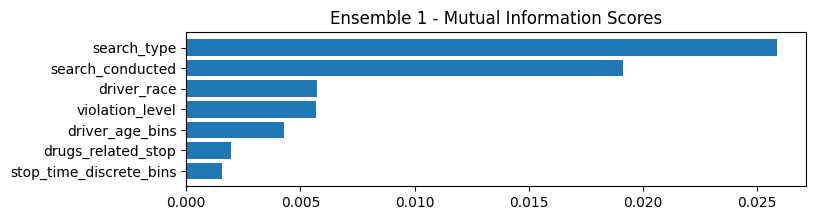

In [325]:

ensemble_1_calculate_mi = CalculateMI(
    df=resampled_ensembled_df_1,
    target="is_arrested",
    baseline_features=mi_baseline_f,
    categorical_features=mi_categorical_f,
)

mi_scores = raw_calculate_mi.calculate_mi_scores()
plot_mi_scores(mi_scores, title="Ensemble 1 - Mutual Information Scores")

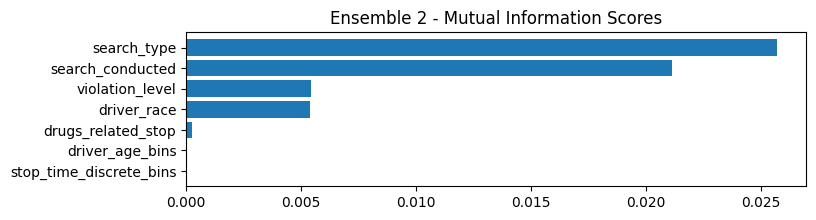

In [326]:
ensemble_2_calculate_mi = CalculateMI(
    df=resampled_ensembled_df_2,
    target="is_arrested",
    baseline_features=mi_baseline_f,
    categorical_features=mi_categorical_f,
)

mi_scores = raw_calculate_mi.calculate_mi_scores()
plot_mi_scores(mi_scores, title="Ensemble 2 - Mutual Information Scores")

## Selecionar Atributos mais Determinantes

In [327]:
most_important_features = [
    "search_type",
    "search_conducted",
    "violation_level",
    "driver_race",
    "drugs_related_stop",
]

## Treinar Uma Árvore de Decisão e Medir a Acurácia

In [328]:
from sklearn import tree
from matplotlib import pyplot as plt

X_tree = resampled_ensembled_df_1.copy()
y_tree = X_tree.pop("is_arrested")
X_tree = pd.get_dummies(X_tree[most_important_features], drop_first=False)

display(print(f"Y => {y_tree.hasnans}"))

clf = tree.DecisionTreeClassifier(random_state=0)
clf = clf.fit(X_tree, y_tree)

Y => False


None

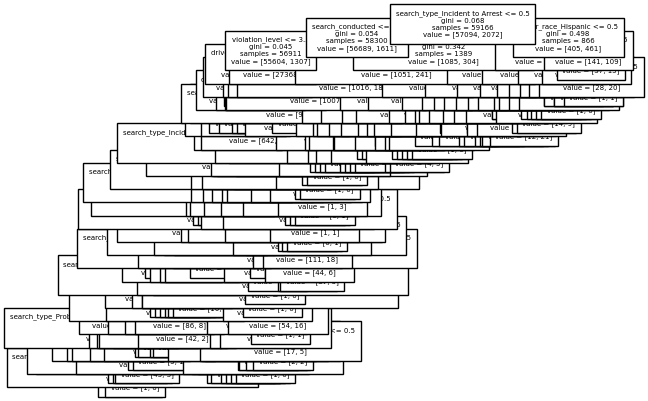

<Figure size 1000x1000 with 0 Axes>

In [329]:
tree.plot_tree(clf, feature_names=X_tree.columns, fontsize=5)
plt.figure(dpi=100, figsize=(10, 10))
plt.show()

In [330]:
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

def test_and_measure_decision_tree(df: pd.DataFrame, features: list, target: str) -> str:
    X_tree = df.copy()
    y_tree = X_tree.pop(target)
    X_tree = pd.get_dummies(X_tree[features], drop_first=False)
    X_tree_train, X_tree_test, y_tree_train, y_tree_test = train_test_split(X_tree, y_tree, test_size=0.2, random_state=42)
    
    clf = tree.DecisionTreeClassifier(random_state=0)
    clf = clf.fit(X_tree_train, y_tree_train)
    y_tree_pred = clf.predict(X_tree_test)
    
    accuracy = accuracy_score(y_tree_test, y_tree_pred)
    return f"Accuracy: {(accuracy * 100):.2f} %"


In [331]:
display(print("Test - Acurácia com as features mais importantes (sem PCA):"))

accuracy = test_and_measure_decision_tree(
    df=featured_df,
    features=most_important_features,
    target="is_arrested",
)

display(print(accuracy))

Test - Acurácia com as features mais importantes (sem PCA):


None

Accuracy: 96.86 %


None

## Aplicar PCA Sobre os Atributos Selecionados Anteriormente

In [339]:
from sklearn.decomposition import PCA

X_tree = featured_df.copy()
X_tree = pd.get_dummies(X_tree[most_important_features], drop_first=False)

n_components = 2 

pca_columns = [f"pca_{i}" for i in range(n_components)]

pca = PCA(n_components=n_components)
police_pca = pca.fit_transform(X_tree)
police_pca_df = pd.DataFrame(data=police_pca, columns=pca_columns)

## Treinar Uma Árvore de Decisão Com os K PCAs Mais Relevantes e Medir a Acurácia

- A acurácia melhorou após a aplicação do PCA?
  - Melhorou apenas 0.01% - insignificante para o contexto

In [340]:
display(print(f"Test - Acurácia com as features mais importantes Com {n_components} PCAs):"))
police_pca_df["is_arrested"] = featured_df["is_arrested"]

accuracy = test_and_measure_decision_tree(
    df=police_pca_df,
    features=pca_columns,
    target="is_arrested",
)

display(print(accuracy))

Test - Acurácia com as features mais importantes Com 2 PCAs):


None

Accuracy: 96.87 %


None